In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
from sqlalchemy import text

# Task 2.7: Improve workflow for non-agricultural diffuse inputs

## Part C: Urban, glacial and lake areas

From the proposal text:

> **Oppgave 2.7: Forbedre arbeidsflyten for ikke-jordbruk diffuse kilder**
> 
> NIVAs eksisterende database over punktutslipp vil bli kombinert med 2019 «1000 Innsjøer» datasettet (Hindar et al., 2020) for å identifisere overvannssjøer med liten eller ingen direkte menneskeskapt tilførsel. Dette datasettet vil bli ytterligere delt inn i to grupper (skog og fjell) basert på dominerende arealdekke, stort sett etter den opprinnelige TEOTIL arbeidsflyten. Romlig interpolering av disse datasettene (potensielt ved bruk av NDVI som en kovariat) vil gi oppdaterte konsentrasjonsbaserte eksportkoeffisienter for DIN, TON, TDP, TPP og TOC fra naturlig land.
> 
> For SS, vil initialtapskoeffisienter for naturområder hentes fra Bogen (1996). Om mulig, vil det genereres romlige og tidsvariable estimater ved bruk av regresjonsligninger utledet fra NVEs overvåkingsnettverk for sediment-transport.
> 
> Tapskoeffisienter fra byområder for alle parametere vil bli modifisert for å bruke den konsentrasjonsbaserte tilnærmingen til Åstebøl et al. (2012), i stedet for de arealbaserte koeffisientene som er i bruk.
> 
> For innsjøer vil atmosfærisk avsetning av N beregnes for hvert reginefelt ved bruk av de siste 5-årsmidler produsert av NILU. Deponering av P vil enten bli fastsatt til 15 kg/km2/år (basert på data fra Birkenes og Møsvatn), eller antatt å være null. Deponering av TOC og SS antas å være ubetydelig.

In Task 2.1, the AR50 dataset was reclassified into 8 categories: Urban, Wood, Upland, Glacier, Lakes, Agricultural, Sea and Other. The new model will also consider 8 parameters: DIN, TON, TOTN, TDP, TPP, TOTP, TOC and SS. Of these, only 6 are independent, as TOTN and TOTP will be calculated by summing the relevant sub-fractions. In principle, this gives $8 \times 6 = 48$ possible diffuse background coefficients, although many of these are considered insignificant and will not be included. The matrix below provides an overview of the data sources for each coefficient (`-` is used for combinations that are not relevant or considered to be insignificant).

| **Land class** |        **DIN**        |        **TON**        |        **TDP**        |        **TPP**        |        **TOC**        |         **SS**        |
|:--------------:|:---------------------:|:---------------------:|:---------------------:|:---------------------:|:---------------------:|:---------------------:|
|    **Urban**   | Åstebøl et al. (2012) | Åstebøl et al. (2012) | Åstebøl et al. (2012) | Åstebøl et al. (2012) | Åstebøl et al. (2012) | Åstebøl et al. (2012) |
|    **Wood**    |       1000 Lakes      |       1000 Lakes      |       1000 Lakes      |       1000 Lakes      |       1000 Lakes      |      Bogen (1996)     |
|   **Upland**   |       1000 Lakes      |       1000 Lakes      |       1000 Lakes      |       1000 Lakes      |       1000 Lakes      |      Bogen (1996)     |
|   **Glacier**  |           -           |           -           |           -           |           -           |           -           |      Bogen (1996)     |
|    **Lakes**   |          EMEP         |           -           |           -           |           -           |           -           |           -           |
|    **Agri**    |         NIBIO         |         NIBIO         |         NIBIO         |         NIBIO         |         NIBIO         |         NIBIO         |
|     **Sea**    |           -           |           -           |           -           |           -           |           -           |           -           |
|    **Other**   |           -           |           -           |           -           |           -           |           -           |           -           |

Converting this table to "long" format and dropping the `-` and agricultural entries gives the following list of background coefficients, some of which are spatially variable (i.e. they change from regine to regine) and some of which are static (i.e. based on literature values). Atmospheric deposition in lakes varies over both space and time, because we have gridded model output from EMEP back to the 1880s. 

Note that some coefficients are expressed as concentrations, so the estimated input fluxes will vary from year to year according to annual runoff, whereas others are area-based and therefore constant unless the land cover map (AR50) is updated.

|   **Variable**   | **Spatially variable?** | **Varies with runoff?** |             **Comment**            |
|:----------------:|:-----------------------:|:-----------------------:|:----------------------------------:|
|   Wood_DIN_µg/l  |           Yes           |           Yes           |    Based on "1000 Lakes" dataset   |
|   Wood_TON_µg/l  |           Yes           |           Yes           |    Based on "1000 Lakes" dataset   |
|   Wood_TDP_µg/l  |           Yes           |           Yes           |    Based on "1000 Lakes" dataset   |
|   Wood_TPP_µg/l  |           Yes           |           Yes           |    Based on "1000 Lakes" dataset   |
|   Wood_TOC_µg/l  |           Yes           |           Yes           |    Based on "1000 Lakes" dataset   |
|  Upland_DIN_µg/l |           Yes           |           Yes           |    Based on "1000 Lakes" dataset   |
|  Upland_TON_µg/l |           Yes           |           Yes           |    Based on "1000 Lakes" dataset   |
|  Upland_TDP_µg/l |           Yes           |           Yes           |    Based on "1000 Lakes" dataset   |
|  Upland_TPP_µg/l |           Yes           |           Yes           |    Based on "1000 Lakes" dataset   |
|  Upland_TOC_µg/l |           Yes           |           Yes           |    Based on "1000 Lakes" dataset   |
|  Urban_DIN_µg/l  |            No           |           Yes           |   Based on Åstebøl et al. (2012)   |
|  Urban_TON_µg/l  |            No           |           Yes           |   Based on Åstebøl et al. (2012)   |
|  Urban_TDP_µg/l  |            No           |           Yes           |   Based on Åstebøl et al. (2012)   |
|  Urban_TPP_µg/l  |            No           |           Yes           |   Based on Åstebøl et al. (2012)   |
|  Urban_TOC_µg/l  |            No           |           Yes           |   Based on Åstebøl et al. (2012)   |
|  Urban_SS_mg/l   |            No           |           Yes           |   Based on Åstebøl et al. (2012)   |
|  Wood_SS_kg/km2  |            No           |            No           |        Based on Bogen (1996)       |
| Upland_SS_kg/km2 |            No           |            No           |        Based on Bogen (1996)       |
|Glacier_SS_kg/km2 |            No           |            No           |        Based on Bogen (1996)       |
|  Lake_DIN_kg/km2 |           Yes           |            No           | Based on deposition data from EMEP |

The notebooks for Task 2.7 parts A and B focused on deriving coefficients based on the 1000 Lakes dataset; this notebook considers the rest.

## 1. Fixed coefficients from Åstebøl et al. (2012) and Bogen (1996) 

[Åstebøl et al. (2012)](https://www.miljodirektoratet.no/sharepoint/downloaditem?id=01FM3LD2XYMQWENJOBOVEL2YIHX3PUTEYP) suggest coefficients for **urban areas** (see Table 4.5 on page 27). They provide separate estimates for "Tett by (> 50% tette flater)" and "Åpen by (< 50% tette flater)", but the AR50 land cover map used for TEOTIL does not distinguish these classes. Having looked at the data in AR50, I believe the definition of "urban" there is closest to "tett by", so I have used those figures for now. This could be revised later if the urban fluxes seem too high.

**Update 21.09.2022:** Testing in several catchments/examples suggests that urban fluxes estimated using the "tett by" coefficients from Åstebøl et al. are much too high. In fact, even the "åpen by" coefficients may be too large. However, for the time being **I will switch to the "åpen by" coefficients**.

In the dataframe below, I have aggregated values from Åstebøl et al. as follows:

 * DIN = NO3 + NH4
 * TON = TOTN - DIN
 * TDP = Oppl. P
 * TPP = TOTP - TDP
 * TOC = 0.2 * COD
 
The last assumption is approximate and based on data from road runoff collected in the USA, where both TOC and COD were measured (see Table 4.3 in Åstebøl et al.). The data presented are limited but, to a first approximation, TOC concentrations are about 20% of COD concentrations for roads. For urban areas, I have therefore estimated TOC concentrations from COD using this factor.

[Bogen (1996)](https://www.researchgate.net/publication/237813476_Erosion_and_Sediment_Yield_in_Norwegian_Rivers) provides typical sediment yields from natural areas in Norway (summarised in [Table 12](https://niva.brage.unit.no/niva-xmlui/bitstream/handle/11250/2985726/7726-2022%2bhigh.pdf?sequence=1&isAllowed=y#page=46) of the forprosjekt report) based on monitoring of a range of Norwegian river systems. In the dataframe below, I have used the **median** yield for each river type from the paper (rather than the mean, as in the forprosjekt), as some of the values are strongly skewed due to major floods. Furthermore, for "glaciers" I have chosen to use the value provided for "glacier fed rivers", rather than "glacier outlets", because this is likely to be more representative of what is actually exported from glacier-dominated headwaters (without lakes).

In [2]:
# Read static coefficients
csv_path = r"../../data/spatially_static_background_coefficients.csv"
static_df = pd.read_csv(csv_path)
static_df

,variable,value
0,urban_din_µg/l,650
1,urban_ton_µg/l,350
2,urban_tdp_µg/l,70
3,urban_tpp_µg/l,80
4,urban_toc_µg/l,7000
5,urban_ss_mg/l,40
6,wood_ss_kg/km2,2000
7,upland_ss_kg/km2,26000
8,glacier_ss_kg/km2,131000


## 2. Atmospheric deposition of N

TEOTIL only considers atmospheric deposition of N **directly to lakes**. As described in the forprosjekt, deposition of P will be assumed to be zero.

EMEP produce gridded time series back to the 1880s. NILU also produce deposition estimates (which are generally regarded as more accurate than the EMEP simulations). However, the NILU estimates are less consistent, as the spatial grid and time periods etc. have changed over time. For TEOTIL we are primarily interested in getting deposition approximately correct, and it is easier to use the EMEP grids for this. Data from both EMEP and NILU are stored in the Hub's `critical_loads` database.

Deposition varies over both space and time. The code below extracts all the EMEP deposition data from 1990 to 2030 and calculates average rates of deposition for each regine. These data are then linearly interpolated through time to give estimates of N deposition per regine for each year from 1990 to 2030.

**Note:** N from atmospheric deposition is generally assumed to be inorganic (NO3 and NH4). All deposition is therefore assumed to be DIN, rather than TON.

In [3]:
# Read tidied regine data
reg_year = 2022
data_fold = f"/home/jovyan/shared/teotil3/core_data_june_{reg_year}"
teo_gpkg = os.path.join(data_fold, "tidied", "teotil3_data.gpkg")
reg_gdf = gpd.read_file(
    teo_gpkg, layer=f"regine_{reg_year}", driver="GPKG"
)

# Get just relevant columns
cols = [
    "regine",
    "vassom",
    "geometry",
]
reg_gdf = reg_gdf[cols]
reg_gdf.head()

,regine,vassom,geometry
0,001.10,001,"MULTIPOLYGON (((297006.830 6543966.950, 297169..."
1,001.1A1,001,"MULTIPOLYGON (((297505.440 6543157.790, 297543..."
2,001.1A20,001,"MULTIPOLYGON (((297770.368 6543429.036, 297787..."
3,001.1A2A,001,"MULTIPOLYGON (((299678.370 6544460.320, 299667..."
4,001.1A2B,001,"MULTIPOLYGON (((303353.460 6552989.330, 303341..."


In [4]:
# Connect to Critical Loads db
eng = nivapy.da.connect_postgis(database="critical_loads")

Connection successful.


In [5]:
# Get deposition time series
st_yr, end_yr = 1990, 2030

# Get list of 'standard' EMEP series from db
sql = text(
    "SELECT * FROM deposition.dep_series_defs "
    "WHERE grid = 'emep' "
    "AND short_name NOT LIKE '%b'"
)
df = pd.read_sql(sql, eng)

# Find series within period of interest
df["year"] = df["name"].str.split(" ", 1, expand=True)[1].astype(int)
df = df.query("@st_yr <= year <= @end_yr")
df.sort_values("year", ascending=True, inplace=True)

# Show series already in database
with pd.option_context("display.max_colwidth", -1):
    display(df)

,series_id,name,short_name,grid,description,year
22,53,EMEP 1990,emep1990,emep,1990 data based on the EMEP 0.50x0.25 degree grid. Includes values for different vegetation classes,1990
23,54,EMEP 1995,emep1995,emep,1995 data based on the EMEP 0.50x0.25 degree grid. Includes values for different vegetation classes,1995
24,55,EMEP 2000,emep2000,emep,2000 data based on the EMEP 0.50x0.25 degree grid. Includes values for different vegetation classes,2000
25,56,EMEP 2005,emep2005,emep,2005 data based on the EMEP 0.50x0.25 degree grid. Includes values for different vegetation classes,2005
26,57,EMEP 2010,emep2010,emep,2010 data based on the EMEP 0.50x0.25 degree grid. Includes values for different vegetation classes,2010
27,58,EMEP 2020,emep2020,emep,2020 data based on the EMEP 0.50x0.25 degree grid. Includes values for different vegetation classes,2020
28,59,EMEP 2030,emep2030,emep,2030 data based on the EMEP 0.50x0.25 degree grid. Includes values for different vegetation classes,2030


In [6]:
def extract_n_deposition_as_gdf(series_id, eng):
    """Extracts DIN deposition (oxidised + reduced N) for the specified series
    as a geodataframe.

    Args:
        series_id: Int. Series ID of interest
        eng:       Obj. Active database connection object

    Returns:
        GeoDataFrame.
    """
    assert isinstance(series_id, int), "'year' must be an integer."

    param_dict = {"series_id": series_id}
    sql = (
        "SELECT ST_Multi(ST_Transform(b.geom, 32633)) AS geom, "
        "  a.cell_id, "
        "  ROUND(a.n_dep) AS ndep_mgpm2pyr "
        "FROM (SELECT cell_id, SUM(value) as n_dep "
        "      FROM deposition.dep_values_emep_grid "
        "      WHERE param_id IN (1, 2) "
        "      AND veg_class_id = 1 "
        "      AND series_id = :series_id "
        "      GROUP BY cell_id) AS a, "
        "deposition.dep_grid_emep AS b "
        "WHERE a.cell_id = b.cell_id"
    )
    sql = text(sql)
    gdf = gpd.read_postgis(sql, eng, params=param_dict)

    return gdf

In [7]:
# Loop over series and calculate mean deposition for each regine
reg_gdf_cea = reg_gdf.to_crs({"proj": "cea"})

df_list = []
for idx, row in df.iterrows():
    series_id = row["series_id"]
    year = row["year"]

    # Get dep data
    dep_gdf = extract_n_deposition_as_gdf(series_id, eng)
    dep_gdf_cea = dep_gdf.to_crs({"proj": "cea"})

    # Intersect with regines
    int_gdf = gpd.overlay(
        reg_gdf_cea, dep_gdf_cea, how="intersection", keep_geom_type=True
    )
    int_gdf["area_km2"] = int_gdf["geometry"].area / 1e6
    int_gdf["DIN_kg"] = int_gdf["area_km2"] * int_gdf["ndep_mgpm2pyr"]

    # Calculate means for each regine
    ag_df = int_gdf.groupby(["regine"]).sum()
    ag_df[f"{year}_lake_din_kg/km2"] = ag_df["DIN_kg"] / ag_df["area_km2"]
    ag_df = ag_df[[f"{year}_lake_din_kg/km2"]]

    df_list.append(ag_df)

dep_df = pd.concat(df_list, axis="columns")

# Add columns for all years
years = range(st_yr, end_yr + 1)
for year in years:
    col = f"{year}_lake_din_kg/km2"
    if col not in dep_df.columns:
        dep_df[col] = np.nan
cols = sorted(dep_df.columns)
dep_df = dep_df[cols]

# Interpolate values for missing years
dep_df.interpolate(method="linear", axis="columns", inplace=True)

assert pd.isna(dep_df).sum().sum() == 0

# Round
for col in dep_df.columns:
    dep_df[col] = dep_df[col].round(0).astype(int)

dep_df.reset_index(inplace=True)
dep_df.head()

,regine,1990_lake_din_kg/km2,1991_lake_din_kg/km2,1992_lake_din_kg/km2,1993_lake_din_kg/km2,1994_lake_din_kg/km2,1995_lake_din_kg/km2,1996_lake_din_kg/km2,1997_lake_din_kg/km2,1998_lake_din_kg/km2,...,2021_lake_din_kg/km2,2022_lake_din_kg/km2,2023_lake_din_kg/km2,2024_lake_din_kg/km2,2025_lake_din_kg/km2,2026_lake_din_kg/km2,2027_lake_din_kg/km2,2028_lake_din_kg/km2,2029_lake_din_kg/km2,2030_lake_din_kg/km2
0,001.10,1092,1060,1028,995,963,931,902,873,844,...,467,464,460,457,453,449,446,442,439,435
1,001.1A1,1092,1060,1028,995,963,931,902,873,844,...,467,464,460,457,453,449,446,442,439,435
2,001.1A20,1092,1060,1028,995,963,931,902,873,844,...,467,464,460,457,453,449,446,442,439,435
3,001.1A2A,1074,1047,1019,991,964,936,912,887,863,...,523,520,517,514,511,508,505,502,499,496
4,001.1A2B,944,920,897,873,850,826,805,783,761,...,472,469,467,465,462,460,457,455,453,450


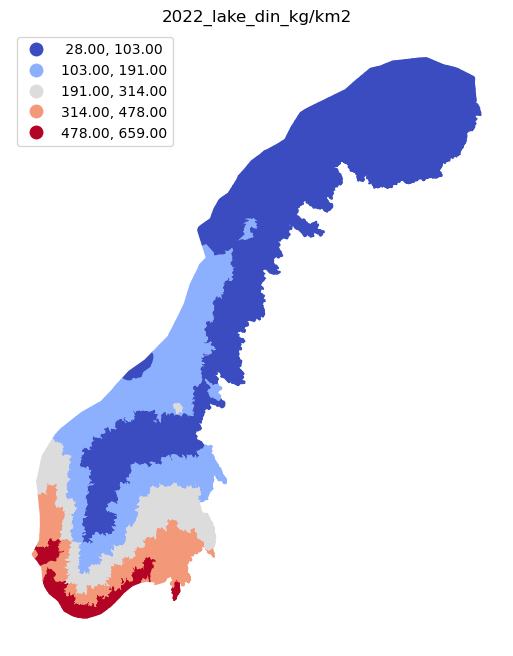

In [8]:
# Join to regines
reg_gdf = pd.merge(reg_gdf, dep_df, on="regine", how="left")

# Plot
col = "2022_lake_din_kg/km2"
ax = reg_gdf.plot(
    column=col,
    legend=True,
    scheme="fisher_jenks",
    edgecolor="face",
    figsize=(8, 8),
    cmap="coolwarm",
    legend_kwds={"loc": "upper left"},
)
ax.axis("off")
ax.set_title(col);

In [9]:
# Save
csv_path = r"../../data/spatiotemporally_variable_background_coefficients.csv"
dep_df.to_csv(csv_path, index=False)